In [26]:
from tool import *
mt=[]
for month in range(1,13):
    now=datetime.datetime.strptime(f'2001-{month}-1', '%Y-%m-%d')
    month_time=(now+relativedelta(months=1)-now).total_seconds()
    mt.append(month_time)
mt=np.array(mt)

In [ ]:
transf.sum()

147898900.0

In [27]:
from tool import *
stat=torch.load(f'/data/hk/albedo/stat_sw-mean_sza-85_band-shortwave_kernel.pth')
_,sza_L=torch.load(root_path+'sza_and_szaL.pth')


energy_all=np.zeros((12,20,18,180,360)).astype(np.float32)
area_all=np.zeros((12,20,18,180,360)).astype(np.float32)
mask=np.zeros((12,20,18,180,360))

for y in range(2001,2021):
    for m in range(1,13):
        energy_all[m-1,y-2001]=stat[f'{y}-{m}-energy']
        area_all[m-1,y-2001]=stat[f'{y}-{m}-typearea']
        mask[m-1,y-2001]=np.expand_dims(sza_L[y-2001,m-1],0).repeat(18,axis=0)
# albedo_all=month_fill(albedo_all,mask>=1)
energy_all[np.isnan(energy_all)]=0
energy_all[mask>=2]=0
energy_all=energy_all*mt.reshape((12,1,1,1,1))
area_all[np.isnan(area_all)]=0
area_all[mask>=2]=0


In [ ]:
-0.07685043597010657

In [ ]:
kka=[]
kka.append(np.zeros((12,180, 360, 18, 18)))
for y in range(2002,2021):
    print(y)
    data_m=torch.load(f'/data/hk/albedo/confuse_matrix/confuse_matrix_{y}.pth')

    mask_t=np.expand_dims(mask[:,0,:],0).repeat(18,axis=0).transpose((1,3,4,0,2))
    data_m[mask_t>=2]=np.nan
    data_m=month_fill(data_m,mask_t>=2)
    data_y=np.nanmean(data_m,axis=0)
    transf=np.nansum(data_y,axis=0)
    transf=np.nansum(transf,axis=0)
    dif_al=[]
    for m in range(12):
        exp1_2020=np.expand_dims(energy_all[m,y-2001]/area_all[m,y-2001],0).repeat(18,axis=0)
        exp0_2001=np.expand_dims(energy_all[m,0]/area_all[m,0],1).repeat(18,axis=1)
        dif_al_m=(exp1_2020-exp0_2001).transpose((2,3,0,1))*data_m[m]
        dif_al.append(dif_al_m)
    print(np.nansum(dif_al_m))
    dif_al=np.stack(dif_al)
    kka.append(dif_al)
    

2002


-1.6576804322126358e+20
2003
-4.8653560555858936e+19
2004
-5.946901588750639e+18
2005
-1.8107639151846207e+19
2006
-4.784742610288962e+19
2007
-1.5419800383467153e+20
2008
-2.814543732317511e+19
2009
-1.7078697921854354e+20
2010
-1.0329746506859948e+20
2011
-8.791993648514564e+19
2012
-1.023173944119523e+20
2013
-9.757200087344125e+19
2014
-1.7518035489091797e+19
2015
-1.522624759342075e+20
2016
-1.3662596401809685e+20
2017
-1.6275137432585073e+20
2018
-1.9019002601176564e+20
2019
-2.2752834577734045e+20
2020
-2.1960752594460475e+20


In [ ]:
kka=np.stack(kka)
kka=kka.transpose((1,0,4,5,2,3))
kka.shape
np.save('/data/hk/albedo/rf_confuse_matrix_kernel.npy',kka)

In [13]:
from tool import *
# kka=np.load('/data/hk/albedo/rf_confuse_matrix_kernel.npy')
# kka=kka2
kka[np.isnan(kka)]=0
season=[]
for month in [[3,4,5],[6,7,8],[9,10,11],[12,1,2]]:
    # month=1
    kk=[]
    for year in range(2001,2021):
        now=datetime.datetime.strptime(f'2001-{month[0]}-1', '%Y-%m-%d')
        month_time=(now+relativedelta(months=3)-now).total_seconds()
        tt=np.array([kka[i-1,year-2001,:,:].sum() for i in month]).sum()/month_time/5.1e8/1e6
        kk.append(tt)
    kk2=[0]+[kk[j]-kk[0] for j in range(1,len(kk))]
    season.append(kk2)
    
stds=[np.std([season[0][i],season[1][i],season[2][i],season[3][i]]) for i in range(20)]
print(stds[-1]/2)
kk2=[]
for y in range(2001,2021):
    ay=np.nansum(kka[:,y-2001,:,:])
    kk2.append(ay/365/24/3600/5.1e8/1e6)
kk=[0]+[kk2[j]-kk2[0] for j in range(1,len(kk2))]
print(kk2[0],kk2[-1],kk2[-1]-kk2[0])
print(mk(kk, alpha=0.05))
print(mann_kendall_test(kk))
plt.figure(figsize=(20,11),dpi=600)
# plt.plot(list(range(2001,2021)),[0]*20,color='#999999',alpha=1,linewidth=1.3)


plt.fill_between([str(int(i)) for i in list(range(2001,2021))],np.array(kk)-np.array(stds)/2,np.array(kk)+np.array(stds)/2,color='thistle',alpha=0.6)

plt.plot([str(int(i)) for i in list(range(2001,2021))],kk,color='plum',alpha=0.7,linewidth=3,label='Global')
plt.plot([str(int(i)) for i in list(range(2001,2021))],[0]*20,color='gray',alpha=0.4,linewidth=3)
# plt.plot([str(int(i)) for i in list(range(2001,2021))],[mk(kk, alpha=0.05)[4][0]*i+mk(kk, alpha=0.05)[4][1] for i in range(1,21)],color='#FA7F6F',alpha=1,linewidth=1.5, linestyle='--')
# plt.annotate('2001 Albedo = 0.2051, Slope = -0.00003 year${^{-1}}$',[9,0],fontsize=20,color='#FA7F6F',rotation=math.atan(mk(kk, alpha=0.05)[4][0]/0.025*10)/3.14159*180)
 





season=[]
for month in [[3,4,5],[6,7,8],[9,10,11],[12,1,2]]:
    # month=1
    kk=[]
    for year in range(2001,2021):
        now=datetime.datetime.strptime(f'2001-{month[0]}-1', '%Y-%m-%d')
        month_time=(now+relativedelta(months=3)-now).total_seconds()
        tt=np.array([kka[i-1,year-2001,:-1,:-1].sum() for i in month]).sum()/month_time/5.1e8/1e6
        kk.append(tt)
    kk2=[0]+[kk[j]-kk[0] for j in range(1,len(kk))]
    season.append(kk2)
    
stds=[np.std([season[0][i],season[1][i],season[2][i],season[3][i]]) for i in range(20)]
print(stds[-1]/2)
kk2=[]
for y in range(2001,2021):
    ay=np.nansum(kka[:,y-2001,:-1,:-1])
    kk2.append(ay/365/24/3600/5.1e8/1e6)
kk=[0]+[kk2[j]-kk2[0] for j in range(1,len(kk2))]
print(kk2[0],kk2[-1],kk2[-1]-kk2[0])
print(mk(kk, alpha=0.05))
print(mann_kendall_test(kk))
# plt.figure(figsize=(20,11),dpi=600)
# plt.plot(list(range(2001,2021)),[0]*20,color='#999999',alpha=1,linewidth=1.3)



plt.fill_between([str(int(i)) for i in list(range(2001,2021))],np.array(kk)-np.array(stds)/2,np.array(kk)+np.array(stds)/2,color='gray',alpha=0.3)

plt.plot([str(int(i)) for i in list(range(2001,2021))],kk,color='gray',alpha=0.6,linewidth=3,label='Snow-free regions')
# plt.plot([str(int(i)) for i in list(range(2001,2021))],[mk(kk, alpha=0.05)[4][0]*i+mk(kk, alpha=0.05)[4][1] for i in range(1,21)],color='gray',alpha=1,linewidth=1.5, linestyle='--')

# plt.plot([str(int(i)) for i in list(range(2001,2021))],[mk(kk, alpha=0.05)[4][0]*i+mk(kk, alpha=0.05)[4][1] for i in range(1,21)],color='#FA7F6F',alpha=1,linewidth=1.5, linestyle='--')
# plt.annotate('2001 Albedo = 0.2051, Slope = -0.00003 year${^{-1}}$',[9,0],fontsize=20,color='#FA7F6F',rotation=math.atan(mk(kk, alpha=0.05)[4][0]/0.025*10)/3.14159*180)
season=[]
for month in [[3,4,5],[6,7,8],[9,10,11],[12,1,2]]:
    # month=1
    kk=[]
    for year in range(2001,2021):
        now=datetime.datetime.strptime(f'2001-{month[0]}-1', '%Y-%m-%d')
        month_time=(now+relativedelta(months=3)-now).total_seconds()
        tt=np.array([kka[i-1,year-2001,-1,:].sum()+kka[i-1,year-2001,:,-1].sum()-kka[i-1,year-2001,-1,-1].sum() for i in month]).sum()/month_time/5.1e8/1e6
        kk.append(tt)
    kk2=[0]+[kk[j]-kk[0] for j in range(1,len(kk))]
    season.append(kk2)
    
stds=[np.std([season[0][i],season[1][i],season[2][i],season[3][i]]) for i in range(20)]
print(stds[-1]/2)
kk2=[]
for y in range(2001,2021):
    ay=np.nansum(kka[:,y-2001,-1,:])+np.nansum(kka[:,y-2001,:,-1])-np.nansum(kka[:,y-2001,-1,-1])
    kk2.append(ay/365/24/3600/5.1e8/1e6)
kk=[0]+[kk2[j]-kk2[0] for j in range(1,len(kk2))]
print(kk2[0],kk2[-1],kk2[-1]-kk2[0])
print(mk(kk, alpha=0.05))
print(mann_kendall_test(kk))
plt.fill_between([str(int(i)) for i in list(range(2001,2021))],np.array(kk)-np.array(stds)/2,np.array(kk)+np.array(stds)/2,color='deepskyblue',alpha=0.3)

plt.plot([str(int(i)) for i in list(range(2001,2021))],kk,color='deepskyblue',alpha=0.6,linewidth=3,label='Snow dynamics')



plt.grid(linestyle='-.')
plt.legend(fontsize=20)
plt.xlim(('2001', '2020'))
# plt.ylim((-0.004, 0.022))
plt.xticks(fontsize=20,rotation=45)
plt.yticks(fontsize=20)
# plt.annotate('2001 Albedo = 0.2200, Slope = 0.00004 $ {y^{-1}}$',[11,0.000],fontsize=20,color='#FA7F6F',rotation=8.42030838e-05*20000)
# plt.annotate('2001 Albedo = 0.1669, Slope = 0.00012 $ {y^{-1}}$',[11,0.001],fontsize=20,color='royalblue',rotation=8.42030838e-05*20000)
# plt.annotate('2001 Albedo = 0.1579, Slope = 0.00019 $ {y^{-1}}$',[11,0.008],fontsize=20,color='#8ECFC9',rotation=0.0050*1200)
# plt.annotate('2001 Albedo = 0.1938, Slope = 0.00008 $ {y^{-1}}$',[11,0.003],fontsize=20,color='black',rotation=8.42030838e-05*36000)


plt.ylabel(r'Albedo-induced radiative forcing (W/m$^2$)',fontsize=20)
# plt.title('2001-2020 yearly albedo',fontsize=20)
plt.savefig('./figure/rf_sw_kernel_snow.pdf',dpi=600)
plt.show()




# ax2.fill_between([str(int(i)) for i in list(range(2001,2021))],(np.array(dif_area_y)-np.array(stds)/2)/1e6,(np.array(dif_area_y)+np.array(stds)/2)/1e6,color='deepskyblue',alpha=0.3)
# # plt.plot(list(range(2001,2021)),np.array(kk)+np.array(stds)/2,color='indigo',linewidth=0.5)
# # plt.plot(list(range(2001,2021)),np.array(kk)-np.array(stds)/2,color='indigo',linewidth=0.5)
# ax2.plot([str(int(i)) for i in list(range(2001,2021))],np.array(dif_area_y)/1e6,color='deepskyblue',alpha=0.7,linewidth=3,label='Snow area')
# ax2.plot([str(int(i)) for i in list(range(2001,2021))],[mk(np.array(dif_area_y)/1e6, alpha=0.05)[4][0]*i+mk(np.array(dif_area_y)/1e6, alpha=0.05)[4][1] for i in range(1,21)],color='deepskyblue',alpha=1,linewidth=1.5, linestyle='--')

0.025323754200885878
0.0 -0.07675277252397239 -0.07675277252397239
(0, 0.12728869225659967, -0.003015983339441819, -1.5248813586291678, [array([-0.00301598]), -0.026159179343212033])
('no trend', 0.12728869225659967)
0.002515186759131889
0.0 -0.12574560560673437 -0.12574560560673437
(-1, 0.0004055786023198227, -0.003644078135982233, -3.5364269806506234, [array([-0.00364408]), -0.042456430058966106])
('decreasing', 0.0004055786023198227)
0.025938359035172543
0.0 0.04899283308276292 0.04899283308276292
(0, 0.5812547604118179, 0.0006280947965404186, 0.5515528318445926, [array([0.00062809]), 0.01629725071575394])
('no trend', 0.5812547604118179)


In [28]:
import numpy as np
from scipy.stats import norm

def mann_kendall_test(x):
    """
    Mann-Kendall trend test for a given data sequence x.
    Args:
        x: A list or numpy array of data sequence.
    Returns:
        trend: The calculated trend (positive, negative or no trend).
        p_value: The p-value of the test.
    """
    alpha=0.05
    n = len(x)
    s = 0
    for i in range(n - 1):
        for j in range(i + 1, n):
            s += np.sign(x[j] - x[i])
    
    # Calculate the variance of the test statistic.
    var_s = (n * (n - 1) * (2 * n + 5)) / 18
    
    # Calculate the standardized test statistic.
    if s > 0:
        z = (s - 1) / np.sqrt(var_s)
    elif s < 0:
        z = (s + 1) / np.sqrt(var_s)
    else:
        z = 0
    
    # Calculate the p-value of the test.
    p_value = 2 * (1 - norm.cdf(abs(z)))
    
    # Determine the trend based on the sign of the test statistic.
    if p_value < alpha:
        if z > 0:
            trend = 'increasing'
        elif z < 0:
            trend = 'decreasing'
        else:
            trend = 'no trend'
    else:
        trend = 'no trend'
    return trend, p_value

In [ ]:
-0.07675277252397221/0.274

-0.2801196077517234

In [29]:
data_m=torch.load('/data/hk/albedo/confuse_matrix/confuse_matrix_2020.pth')

mask_t=np.expand_dims(mask[:,0,:],0).repeat(18,axis=0).transpose((1,3,4,0,2))
data_m[mask_t>=2]=np.nan
data_m=month_fill(data_m,mask_t>=2)
data_y=np.nanmean(data_m,axis=0)
transf=np.nansum(data_y,axis=0)
transf=np.nansum(transf,axis=0)
dif_al=[]
for m in range(12):
    exp1_2020=np.expand_dims(energy_all[m,-1]/area_all[m,-1],0).repeat(18,axis=0)
    exp0_2001=np.expand_dims(energy_all[m,0]/area_all[m,0],1).repeat(18,axis=1)
    dif_al_m=(exp1_2020-exp0_2001).transpose((2,3,0,1))*data_m[m]
    dif_al.append(dif_al_m)
dif_al=np.stack(dif_al)
print('delta albedo:',np.nansum(dif_al)/365/24/3600/5.1e8/1e6)
print('')




print('计算方法为和雪的扩张和收缩造成的albedo都归因于雪')
print('type        nochange              add+sub               all')
temp=0
temp2=0
all=np.nansum(dif_al)
for t in range(18):

    if t==17:
        nc=np.nansum(dif_al[:,:,:,t,t])
        sub=np.nansum(dif_al[:,:,:,t])-nc
        add=np.nansum(dif_al[:,:,:,:,t])-nc
        print(type_code[t],'     ',
            to_str(nc/365/24/3600/5.1e8/1e6,k=4,l=10),'     ',
            to_str(add/365/24/3600/5.1e8/1e6,k=5,l=10),'     ',
            to_str(sub/365/24/3600/5.1e8/1e6,k=5,l=10),'     ',
            to_str((nc+(sub+add))/365/24/3600/5.1e8/1e6,k=4,l=10),'     ',)
        temp2+=(sub+add)
    else:
        nc=np.nansum(dif_al[:,:,:,t,t])
        sub=np.nansum(dif_al[:,:,:,t,:-1])-nc
        add=np.nansum(dif_al[:,:,:,:-1,t])-nc
        print(type_code[t],'     ',
            to_str(nc/365/24/3600/5.1e8/1e6,k=4,l=10),'     ',
            to_str((sub+add)/365/24/3600/5.1e8/1e6,k=6,l=10),'     ',
            # to_str(sub/365/24/3600/5.1e8/1e6,k=5,l=10),'     ',
            to_str((nc+(sub+add))/365/24/3600/5.1e8/1e6,k=4,l=10),'     ',)
        temp2+=(sub+add)/2
    temp+=nc
print('')
print('nochange:',temp/365/24/3600/5.1e8/1e6)
print('change:',(temp2)/365/24/3600/5.1e8/1e6)
print('')
print('nochange except snow:',(temp-nc)/365/24/3600/5.1e8/1e6)
print('change except snow:',(temp2-sub-add)/365/24/3600/5.1e8/1e6)
print('')
print('nochanged snow:',nc/365/24/3600/5.1e8/1e6)
print('changed snow:',(sub+add)/365/24/3600/5.1e8/1e6)

delta albedo: -0.07675277252397221

计算方法为和雪的扩张和收缩造成的albedo都归因于雪
type        nochange              add+sub               all
EN_Forests                     -0.0014          -0.001592        -0.003          
EB_Forests                     0.0051           -0.003935        0.0011          
DN_Forests                     0.0001           6.9e-05          0.0002          
DB_Forests                     -0.0007          -0.001298        -0.002          
M_Forests                      -0.0027          -0.000918        -0.0036         
C_Shrublands                   -0.0011          -0.001478        -0.0026         
O_Shrublands                   -0.0387          -0.00098         -0.0397         
W_Savannas                     -0.0048          -0.006818        -0.0116         
Savannas                       -0.0127          -0.00885         -0.0216         
Grasslands                     -0.0319          -0.009277        -0.0412         
Permanent_Wetlands             -0.0008          4.7e-05 

In [ ]:
0.05418863910983961-0.0051958060270767955-0.01711953447788339-0.10862607112885166

-0.07675277252397222

In [ ]:
(-0.10862607112885166-0.01711953447788339)

-0.12574560560673503

In [ ]:
0.10862607112885166/0.01711953447788339

6.34515332582115

In [ ]:
0.07675277252397221/0.3400000000000001

0.2257434485999182

In [ ]:
0.049/0.07675277252397221

0.6384134199803118

In [ ]:
-0.07675277252397221/(2.156-1.882)

-0.2801196077517231

In [ ]:
-0.07675277252397221/(3.317-2.981)

-0.22843087060705994

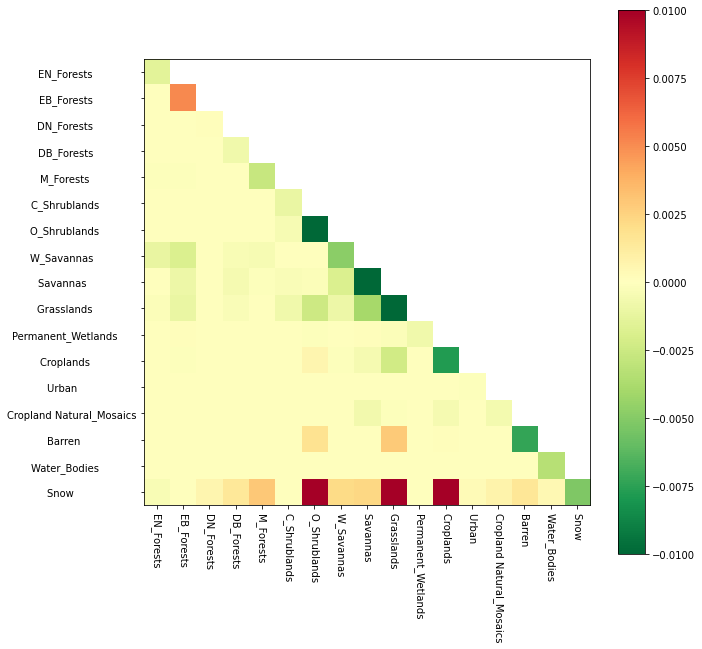

In [30]:
dif_al_tranf=np.nansum(dif_al.reshape(-1,18,18),axis=0)
dif_al_tranf=dif_al_tranf/365/24/3600/5.1e8/1e6
dif_al_tranf=np.delete(dif_al_tranf,14,axis=0)
dif_al_tranf=np.delete(dif_al_tranf,14,axis=1)


dif_al_tranf2=np.zeros((17,17))
for x in range(17):
    for y in range(17):
        dif_al_tranf2[x,y]=(dif_al_tranf[y,x]+dif_al_tranf[x,y])
        dif_al_tranf2[y,x]=np.nan
for i in range(17):
    dif_al_tranf2[i,i]=dif_al_tranf[i,i]

ll=[type_code[i] for i in range(18) if i!=14]


initial_cmap = cm.get_cmap('RdYlGn')
reversed_cmap = initial_cmap.reversed()
#x to y 减去y to x
plt.figure(figsize=(10,10))
plt.imshow(dif_al_tranf2,vmax=0.01,vmin=-0.01,cmap=reversed_cmap)
plt.yticks([i for i in range(17)],ll)
plt.xticks([i for i in range(17)],ll)
plt.xticks(rotation=-90)
plt.colorbar()
plt.show()

In [ ]:
np.nansum(dif_al_tranf2[-3])+np.nansum(dif_al_tranf2[:,-3])-dif_al_tranf2[-3,-3]*2

0.006370125925444621

In [31]:
def to_log(k):
    k=k*1e5
    if np.isnan(k):
        return np.nan
    else:
        if k>=0:
            k=np.log10(k)
            if k<0:
                k=0
            return k
        else:
            k=np.log10(k*(-1))
            if k<0:
                k=0
            return -k
dif_al_tranf3=dif_al_tranf2.copy()
for x in range(17):
    for y in range(17):
        dif_al_tranf3[x,y]=to_log(dif_al_tranf3[x,y])
dif_al_tranf4=dif_al_tranf2.copy()
dif_al_tranf4=np.round(dif_al_tranf4*1e5)
# dif_al_tranf4=dif_al_tranf4.astype(np.int32)


In [32]:
data_m=torch.load('/data/hk/albedo/confuse_matrix/confuse_matrix_2020.pth')
mask_t=np.expand_dims(mask[:,0,:],0).repeat(18,axis=0).transpose((1,3,4,0,2))
data_m[mask_t>=2]=np.nan
data_m=month_fill(data_m,mask_t>=2)
data_y=np.nanmean(data_m,axis=0)
transf=np.nansum(data_y,axis=0)
transf=np.nansum(transf,axis=0)
transf2=transf.copy()
transf22=np.zeros((18,18))
for i in range(18):
    transf22[i,i]=0
for x in range(18):
    for y in range(18):
        transf22[x,y]=(transf2[y,x]-transf2[x,y])
        transf22[y,x]=0
# for i in range(18):
#     transf22[i,i]=transf2[i,i]
transf22[transf22==0]=np.nan
transf3=np.zeros((17,17))
transf3[:14,:14]=transf22[:14,:14]
transf3[14:,:14]=transf22[15:,:14]

transf3[:14,14:]=transf22[:14,15:]
transf3[14:,14:]=transf22[15:,15:]
box_indices=[]
for x in range(17):
    for y in range(17):  
        if transf3[x,y]<0:
          box_indices.append((x,y))  

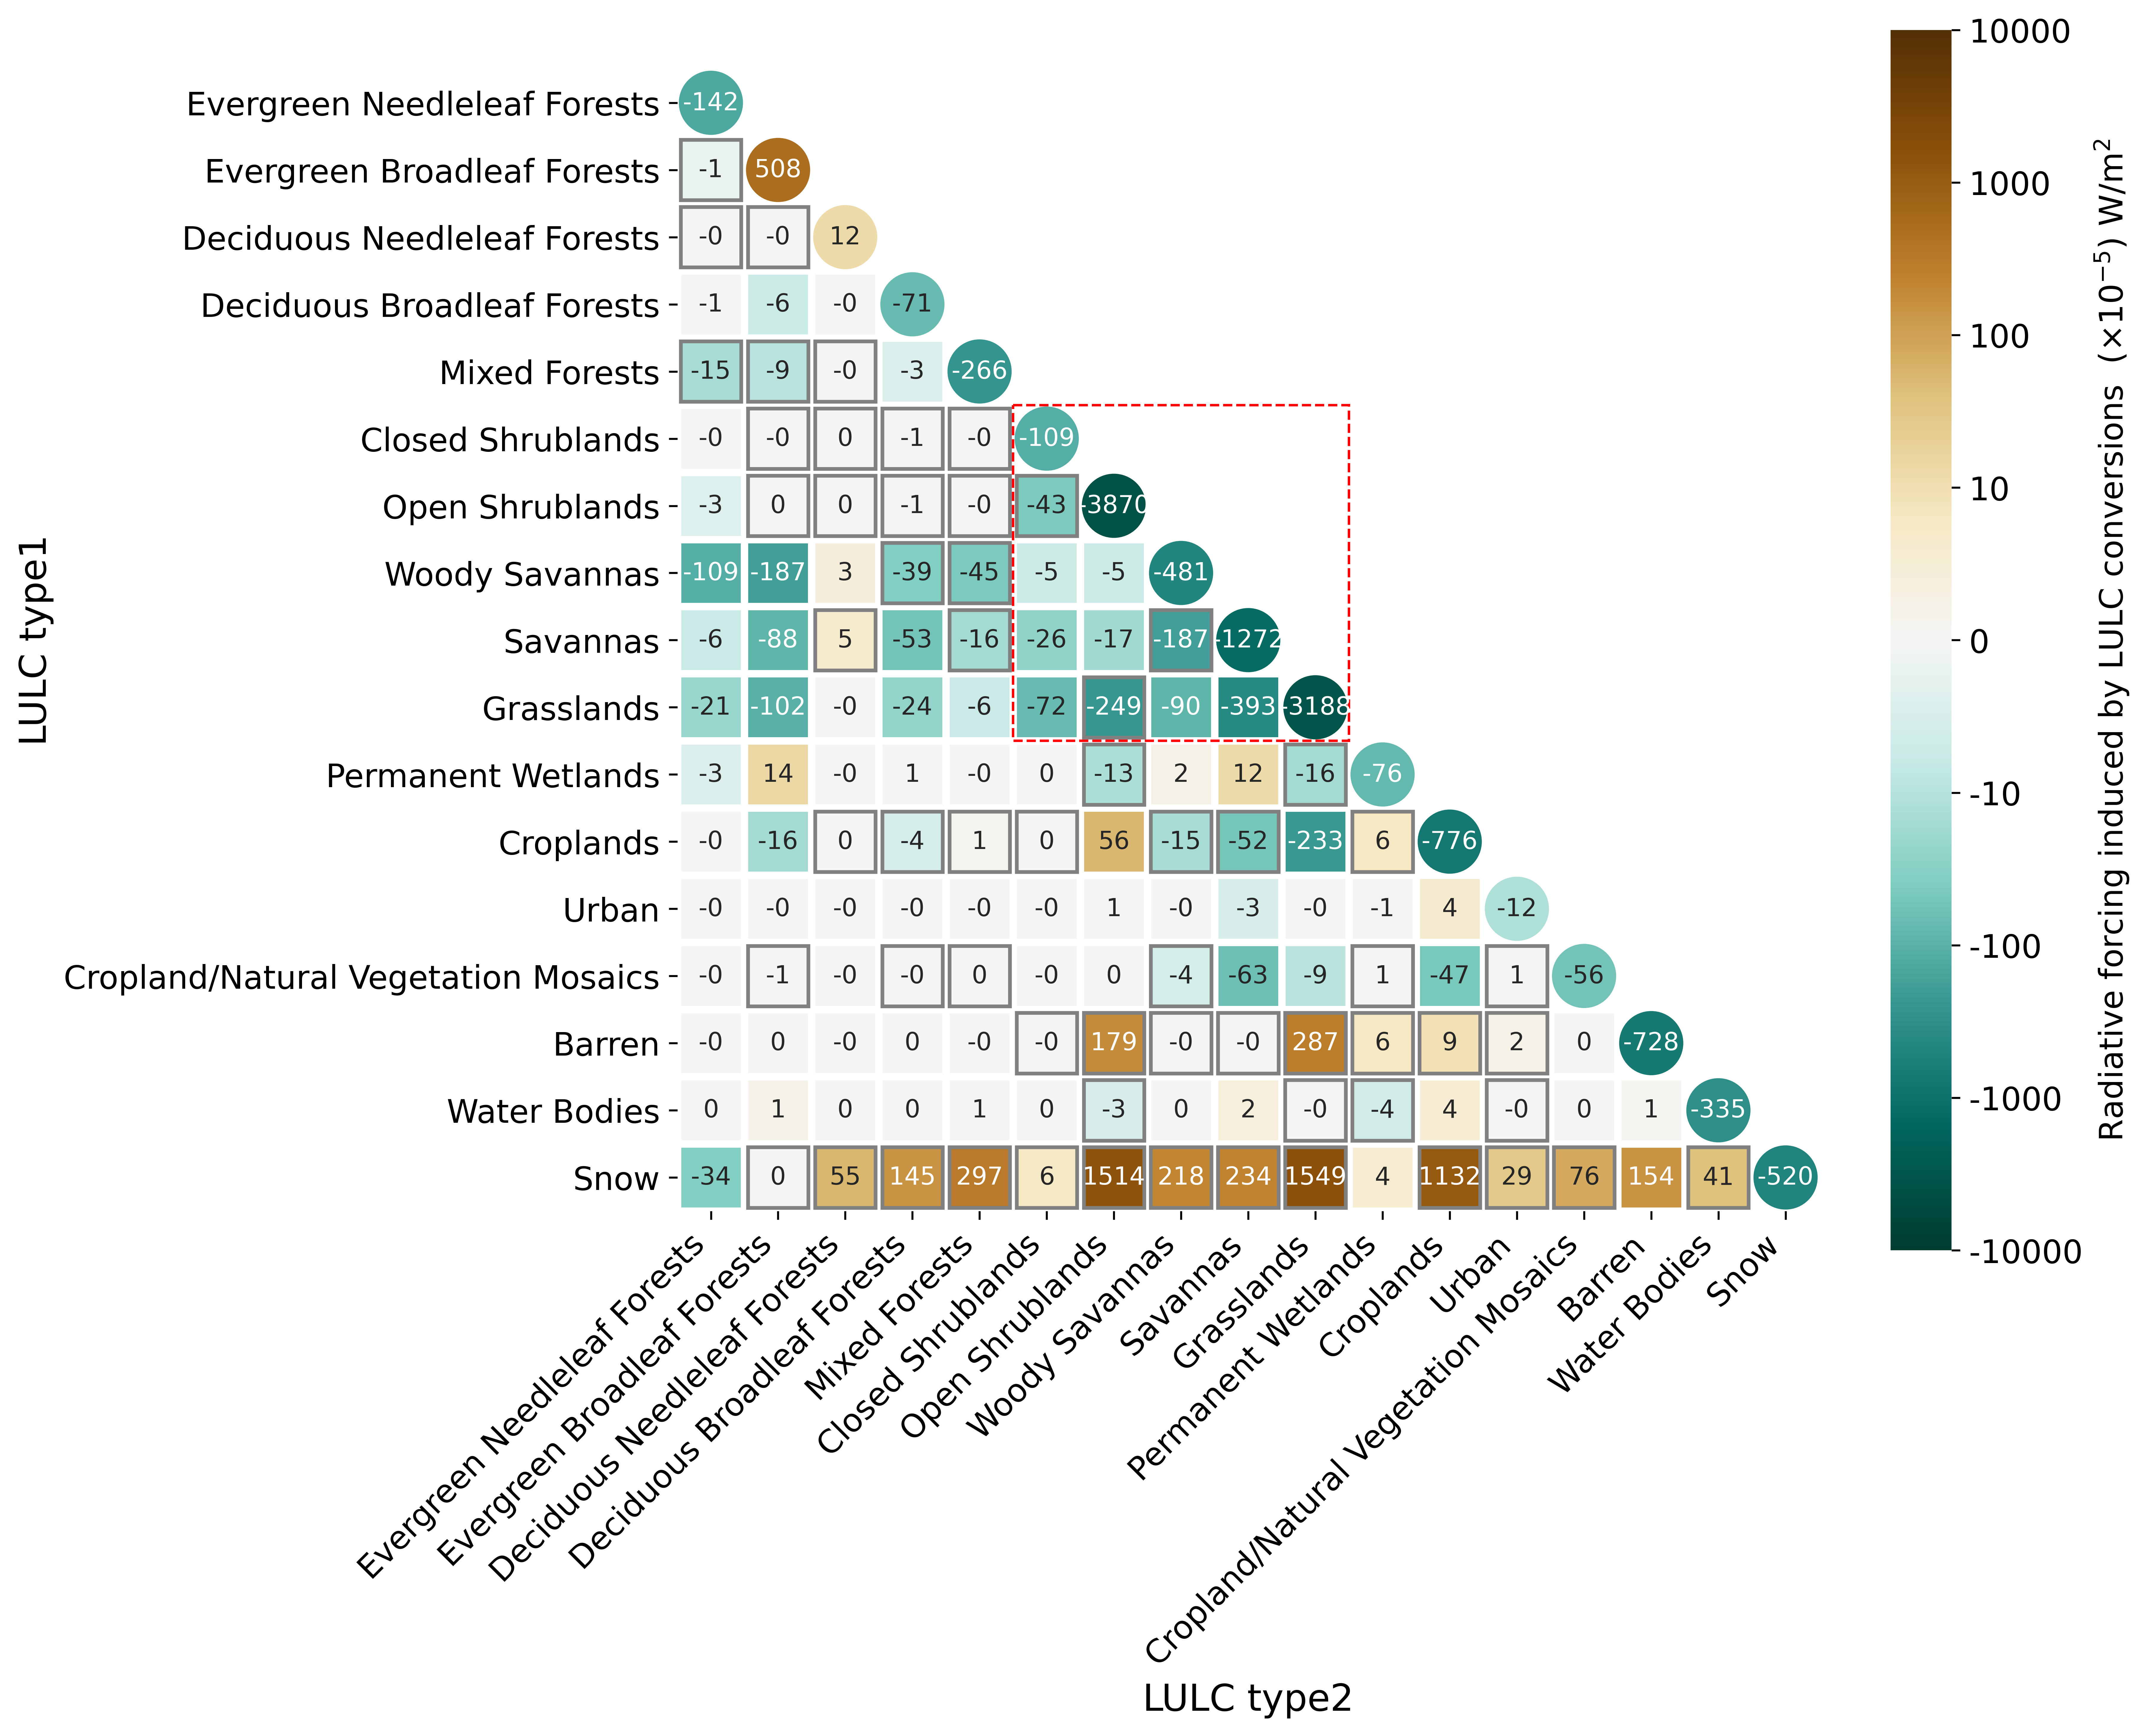

In [36]:
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
import seaborn as sns
names=['Evergreen Needleleaf Forests',
 'Evergreen Broadleaf Forests',
 'Deciduous Needleleaf Forests',
 'Deciduous Broadleaf Forests',
 'Mixed Forests',
 'Closed Shrublands',
 'Open Shrublands',
 'Woody Savannas',
 'Savannas',
 'Grasslands',
 'Permanent Wetlands',
 'Croplands',
 'Urban',
 'Cropland/Natural Vegetation Mosaics',
 'Barren',
 'Water Bodies',
 'Snow']
def heatmap_with_boxes(data, box_indices, ax=None, **kwargs):
    if not ax:
        ax = plt.gca()
    # ax.imshow(data, **kwargs)

    rows, cols = data.shape

    for i, j in box_indices:
        # 计算框的左下角坐标
        x = j
        y = i

        # 创建框对象并添加到图表中
        rect = Rectangle((x+0.05, y+0.05), 1-0.1, 1-0.1, linewidth=1.5, edgecolor='gray', facecolor='none')
        ax.add_patch(rect)

    ax.set_aspect('equal', adjustable='box')
def heatmap_with_c(data, box_indices, ax=None, **kwargs):
    if not ax:
        ax = plt.gca()
    # ax.imshow(data, **kwargs)

    rows, cols = data.shape
    cmap = plt.get_cmap('BrBG_r')
    norm = plt.Normalize(vmin=-4, vmax=4)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    for i, j in box_indices:
        # 计算框的左下角坐标
        x = j
        y = i


        value = data[x,y]
        color = sm.to_rgba(value)
        # 创建框对象并添加到图表中
        rect = Circle((x+0.5, y+0.5), 0.45, linewidth=1.5, edgecolor=color, facecolor=color)
        rect2 = Rectangle((x+0.05, y+0.05), 1, 1, linewidth=1.5,  facecolor='white')
        ax.add_patch(rect2)
        ax.add_patch(rect)
        

    ax.set_aspect('equal', adjustable='box')
f, ax = plt.subplots(figsize=(12, 10),dpi=600)
sns.heatmap(dif_al_tranf3, ax=ax,vmin=-4,vmax=4,fmt='g',
            annot_kws={"fontsize":10},square=True,cmap='BrBG_r',
            annot=dif_al_tranf4,linewidths=3,cbar=True)

# ax.set_title('Contribution of LULC conversions to global mean albedo') #plt.title('热图'),均可设置图片标题
ax.set_ylabel('LULC type1',fontsize=15)  #设置纵轴标签
ax.set_xlabel('LULC type2',fontsize=15)  #设置横轴标签
plt.yticks([i+0.5 for i in range(17)],names)
plt.xticks([i+0.5 for i in range(17)],names)
plt.yticks(rotation=360, horizontalalignment='right',fontsize=13)
plt.xticks(rotation=45, horizontalalignment='right',fontsize=13)
cbar = ax.collections[0].colorbar
cbar.set_ticks([-4,-3,-2,-1, 0,1,2,3, 4])
cbar.set_ticklabels(['-10000','-1000','-100','-10', '0','10','100','1000', '10000'],fontsize=13)
cbar.set_label(r"Radiative forcing induced by LULC conversions  ($\times 10^{-5}$) W/m$^2$",fontsize=13)

# box_indices = [(2, 2), (3, 3)]

# 在指定位置添加框
heatmap_with_c(dif_al_tranf3, [(i,i) for i in range(17)], ax=ax)
heatmap_with_boxes(dif_al_tranf3, box_indices, ax=ax)

# plt.axhline(y=5, color='r', linestyle='--', linewidth=1)
# plt.axhline(y=10, color='r', linestyle='--', linewidth=1)
# plt.axvline(x=5, color='r', linestyle='--', linewidth=1)
# plt.axvline(x=10, color='r', linestyle='--', linewidth=1)
rect = Rectangle((5, 5), 5, 5, linestyle='--',linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
# plt.colorbar(ticks=['10000','1000','100','10','0','-10','-100','-1000','-10000'])
#设置坐标字体方向，通过rotation参数可以调节旋转角度
# label_y = ax.get_yticklabels(names)
# # plt.setp(names, rotation=360, horizontalalignment='right')
# label_x = ax.get_xticklabels(names)
# plt.setp(names, rotation=45, horizontalalignment='right')
plt.tight_layout()
f.savefig('./figure/albedo_RF_kernel_bigfontsize.pdf',dpi=600)
plt.show()

In [ ]:
albedo=torch.load('./albedo_matrix.pth')
RF=torch.load('./RF_matrix.pth')
area=torch.load('./area_matrix.pth')
# 0.0014960914
# -0.07675277252397221w/m2


0.004823371859094665

In [ ]:
5.915444126003422e-05/0.0014957747436673552

0.03954769360191146

In [ ]:
albedo_zero=albedo.copy()
for i in range(17):
    albedo_zero[i,i]=0
RF_zero=RF.copy()
for i in range(17):
    RF_zero[i,i]=0


In [ ]:
(albedo_zero[9,1]+albedo_zero[8,1]+albedo_zero[7,1])

8.040021384658758e-05

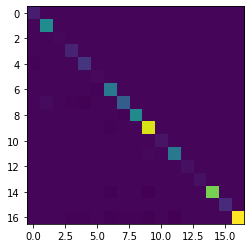

In [ ]:
plt.imshow(area)

In [ ]:
for i in range(17):
    print(i,albedo[i,i],albedo[i,i]/0.0014957747436673552*100,RF[i,i],RF[i,i]/(-0.07675277252397221)*100)

0 4.6688266593264416e-05 3.1213434235955653 -0.0014227581896661106 1.8536896360606914
1 -0.0001252843940164894 -8.375886445930746 0.005082720407078091 -6.622197791604992
2 -5.1885876928281505e-06 -0.346882959135058 0.00011644922400926979 -0.15171989255879867
3 2.148148269043304e-05 1.4361442310333794 -0.0007111958810342821 0.9266061116061366
4 7.01106182532385e-05 4.687244423003198 -0.002658246183829921 3.4633878313642295
5 2.4727711206651293e-05 1.6531707940210065 -0.0010917808263372966 1.4224643494100497
6 0.0009973946725949645 66.6808071748519 -0.03869766406663671 50.41858788169543
7 0.00011603541497606784 7.757546078868203 -0.004810261863530469 6.267215769994601
8 0.00024068757193163037 16.091164324750544 -0.012718078676302197 16.570187965952574
9 0.00077958864858374 52.11938842290764 -0.031883495717588986 41.54051335100736
10 2.5992423616116866e-05 1.7377231248328466 -0.0007641473005963147 0.9955956970253399
11 0.0002538661065045744 16.97221507311609 -0.0077629452968612945 10.1142

In [ ]:
print(albedo_zero[7:9,1].sum())
print(RF_zero[7:9,1].sum())

5.915444126003422e-05
-0.0027456223466676122


In [ ]:
0.0023351090353571635/0.0014957747436673552

1.561136825744176

In [ ]:
albedo.sum()-albedo_zero.sum()-albedo[-2,-2]-albedo[-3,-3]

0.0023351090353571635

In [ ]:
-0.1031982505727234/(-0.07675277252397221)

1.3445540425330105

In [ ]:
RF.sum()-RF_zero.sum()-RF[-2,-2]-RF[-3,-3]

-0.1031982505727234

In [ ]:
RF_zero[12,:-1].sum()+RF_zero[:-1,12].sum()-RF_zero[12,12]*2

2.0564787014909536e-05

In [ ]:
RF[-3,:10].sum()

0.004657455477909525

In [ ]:
RF_zero[-3,:10].sum()

0.004657455477909525

In [ ]:
'''
对比Ghimire和IPCC（CMIP5/6模拟） 1700-2005或者1750-2019土地变化都导致0.15w/m2
大概-0.00049 w/m2/year

'''
#除雪之外的土地转换-草原到草地5种类别的类内转换-森林间的转换+湿地和水体的转换-农田/自然混合类型和农田的转换-裸土相关转换
all=-0.0171195344778834+0.010872907442790845+0.00034958612726890444+4.1229797907037555e-05+0.0004747767470713228-0.004657455477909525
print(all)
print(all/19)

-0.010038489840754814
-0.0005283415705660429


In [ ]:
torch.save(dif_al_tranf2,'./albedo_matrix.pth')

In [ ]:
dif_al_tranf_use=dif_al_tranf2.copy()
dif_al_tranf_use[np.isnan(dif_al_tranf_use)]=0
dif_al_tranf_use.sum()

-0.07675277252397178

In [ ]:
dif_al_tranf_use[:-1,:-1].sum()

-0.12574560560673484

In [ ]:
list(range(1,18))[0:5]

[1, 2, 3, 4, 5]

In [ ]:
for i in range(17):
    dif_al_tranf_use[i,i]=0

In [ ]:
dif_al_tranf_use[-3,:].sum()+dif_al_tranf_use[:,-3].sum()

0.006370125925444621

In [ ]:
RF[-3,:].sum()-RF[-3,-3]

0.004823371859094665

In [ ]:
'''
对比Ghimire和IPCC（CMIP5/6模拟） 1700-2005或者1750-2019土地变化都导致0.15w/m2
大概-0.00049 w/m2/year

'''
#除雪之外的土地转换-草原到草地5种类别的类内转换-森林间的转换+湿地和水体的转换-农田/自然混合类型和农田的转换-裸土相关转换
all=-0.0171195344778834+0.010872907442790845+0.00034958612726890444+4.1229797907037555e-05+0.0004747767470713228-0.006370125925444621
print(all)
print(all/19)

-0.01175116028828991
-0.000618482120436311


In [ ]:
dif_al_tranf_use

In [ ]:
0.010872907442790845/-0.07675277252397221

-0.14166142909554058

In [ ]:
from tool import *
'''
对比NC 2001-2018城市扩张导致0.00017w/m2
'''
kka=np.load('/data/hk/albedo/rf_confuse_matrix_kernel.npy')
# # kka=kka2
kka[np.isnan(kka)]=0
dif_al=kka[:,2018-2001]
dif_al=dif_al.transpose((0,3,4,1,2))
print('type          add         sub               all')
temp=0
temp2=0
all=np.nansum(dif_al)
t=12

print('no snow')
nc=np.nansum(dif_al[:,:,:,t,t])
sub=np.nansum(dif_al[:,:,:,t,-1])-nc
add=np.nansum(dif_al[:,:,:,:-1,t])-nc
print(type_code[t],'     ',
    # to_str(nc/365/24/3600/5.1e8/1e6,k=7,l=10),'     ',
    to_str(add/365/24/3600/5.1e8/1e6,k=7,l=10),'     ',
    to_str(sub/365/24/3600/5.1e8/1e6,k=7,l=10),'     ',
    to_str(((sub+add))/365/24/3600/5.1e8/1e6,k=7,l=10),'     ',)
temp2+=(sub+add)
    # if t==17:
print('have snow')
nc=np.nansum(dif_al[:,:,:,t,t])
sub=np.nansum(dif_al[:,:,:,t])-nc
add=np.nansum(dif_al[:,:,:,:,t])-nc
print(type_code[t],'     ',
    # to_str(nc/365/24/3600/5.1e8/1e6,k=7,l=10),'     ',
    to_str(add/365/24/3600/5.1e8/1e6,k=7,l=10),'     ',
    to_str(sub/365/24/3600/5.1e8/1e6,k=7,l=10),'     ',
    to_str(((sub+add))/365/24/3600/5.1e8/1e6,k=7,l=10),'     ',)
temp2+=(sub+add)


type          add         sub               all
no snow
Urban                          3.8e-06          2.83e-05         3.21e-05        
have snow
Urban                          0.0003138        -0.0001942       0.0001196       
